### Source Material
This notebook follows along the PyMC3 tutorial ["Getting started with PyMC3"](https://docs.pymc.io/notebooks/getting_started.html)

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

In [6]:
%matplotlib inline

## Bayesian Modeling 

### Motivating Example: Linaer Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. 

#### Generating Data

In [5]:
np.random.seed(123)

# true parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# size of dataset
size = 100

# predictor variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma 

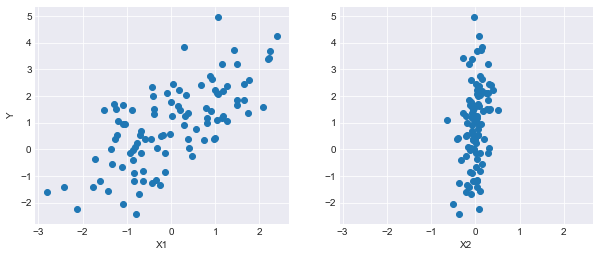

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,4))
ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax1.set_xlabel("X1"); ax1.set_ylabel("Y"); ax2.set_xlabel("X2")
pass

#### Model Specification

In [17]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [18]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

#### Model Fitting
##### Maximum a posteriori methods
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution.

In [20]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 2623.60it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

`find_MAP` also allows selection of other optimization algorithms from the scipy.optimize module.

In [21]:
map_estimate = pm.find_MAP(model=basic_model, method='powell')
map_estimate

  0%|          | 0/5000 [00:00<?, ?it/s]/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 3073.40it/s] 


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. In summary, while PyMC3 provides the function find_MAP(), at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

In [25]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3511.63draws/s]


In [26]:
trace['alpha'][-5:]

array([0.88809936, 0.90610983, 0.95913345, 0.98332898, 0.98332898])

In [32]:
trace.varnames

['alpha', 'beta', 'sigma_log__', 'sigma']

Why 2000, not 500?

In [39]:
trace['beta'].shape

(2000, 2)

In [41]:
# with a different sampling algorithm
with basic_model:
    # instantiate sampler
    step = pm.Slice()
    
    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:09<00:00, 2398.58draws/s]


#### Posterior Analysis

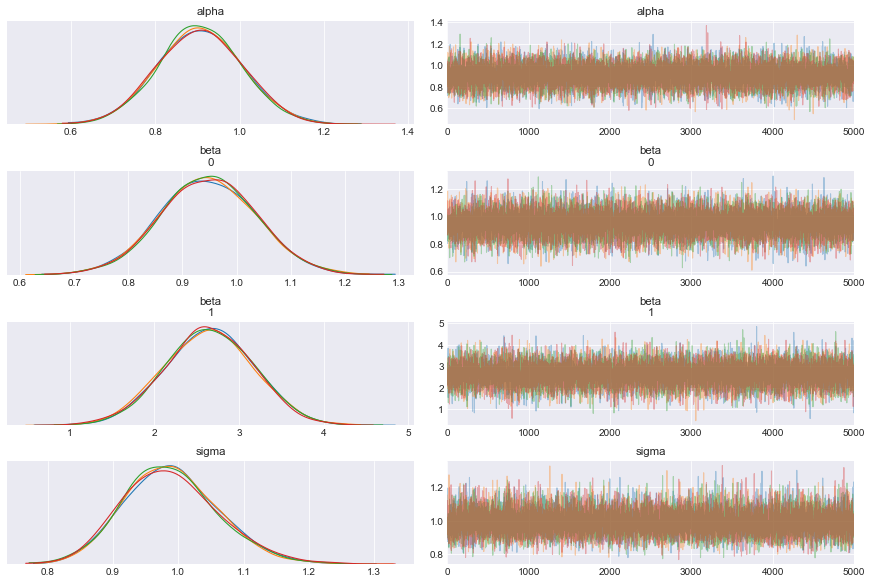

In [47]:
pm.traceplot(trace, compact=False)
pass

In [48]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.10,0.73,1.10,0.0,0.0,19604.0,19510.0,19588.0,14677.0,1.0
beta[0],0.95,0.09,0.78,1.11,0.0,0.0,19470.0,19420.0,19464.0,15030.0,1.0
beta[1],2.65,0.52,1.70,3.63,0.0,0.0,16513.0,15602.0,16476.0,12880.0,1.0
sigma,0.99,0.07,0.86,1.13,0.0,0.0,17939.0,17728.0,18160.0,14878.0,1.0


### Case study 1: Stochastic volatility

#### Getting the data

In [52]:
returns = pd.read_csv(pm.get_data("SP500.csv"), parse_dates=True, index_col=0)
len(returns)

2906

In [56]:
returns.Close.diff()/returns.Close

Date
2008-05-02         NaN
2008-05-05   -0.004554
2008-05-06    0.007594
2008-05-07   -0.018448
2008-05-08    0.003656
                ...   
2019-11-08    0.002554
2019-11-11   -0.001966
2019-11-12    0.001562
2019-11-13    0.000711
2019-11-14    0.000836
Name: Close, Length: 2906, dtype: float64

In [60]:
returns.head()

,Close,change
Date,,
2008-05-02,1413.900024,0.003230
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663


Text(0, 0.5, 'daily returns in %')

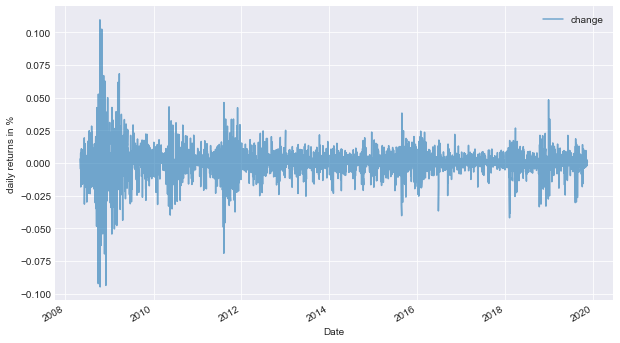

In [62]:
returns.plot(y='change', alpha=0.6, figsize=(10,6))
plt.ylabel("daily returns in %")

#### Model Specification

In [65]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)
    
    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', 
                                          pm.math.exp(-2*s)**0.5)
    
    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['change'])

#### Fitting

In [66]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [05:21<00:00, 31.13draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
The estimated number of effective samples is smaller than 200 for some parameters.


/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17b239850>,
      dtype=object)

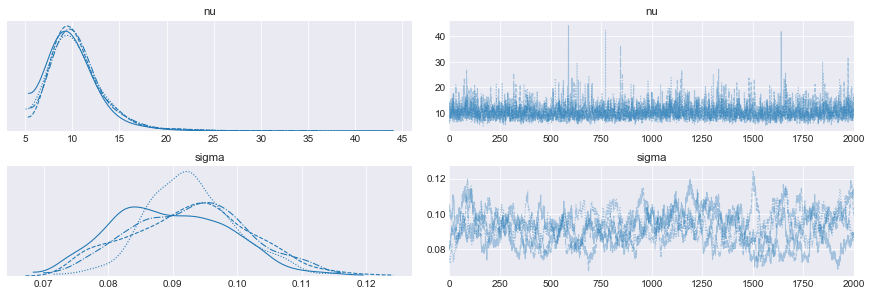

In [73]:
pm.traceplot(trace, varnames=['nu', 'sigma'])

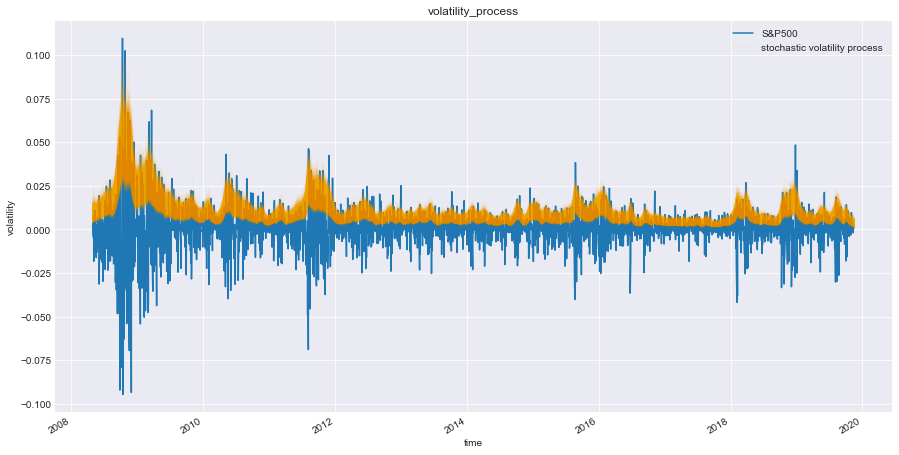

In [70]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.change.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s', ::5].T), 'orange', alpha=0.03)
ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'stochastic volatility process'])

### Case study 2: Coal mining disasters

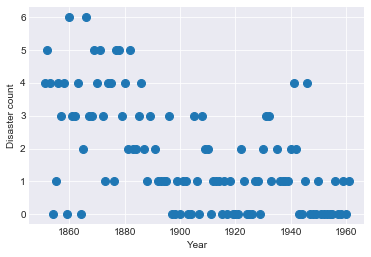

In [74]:
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

#### Model Specification

In [75]:
with pm.Model() as disaster_model:
    
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)
    
    # Priors for pre and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    
    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


#### Fitting and Sampling

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we will sample using a Metroplis step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC3 automatically assigns the correct sampling algorithms.

In [76]:
with disaster_model:
    trace = pm.sample(10000)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:12<00:00, 3325.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


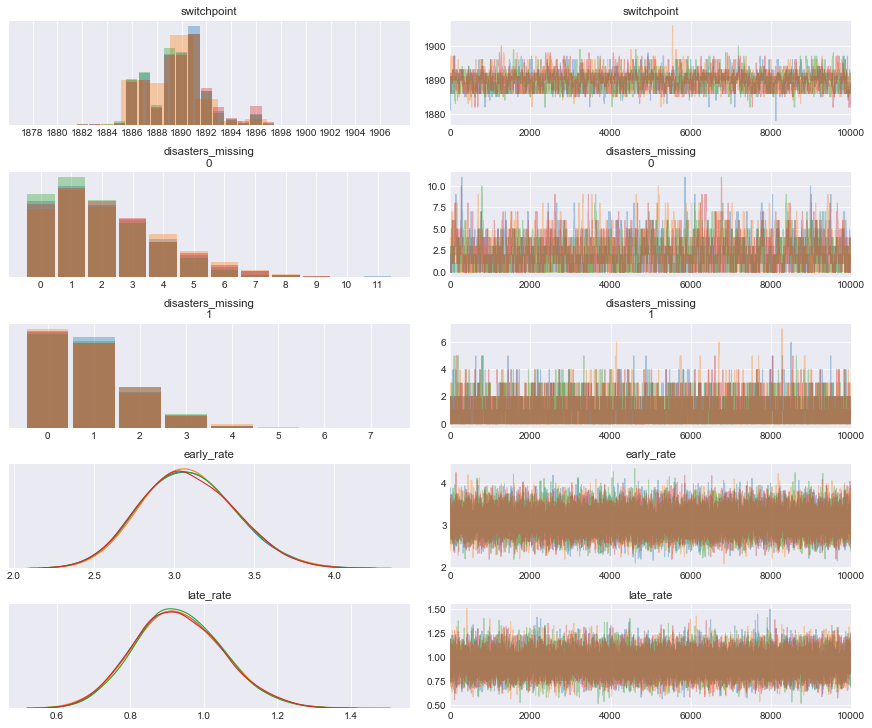

In [77]:
pm.traceplot(trace, compact=False);

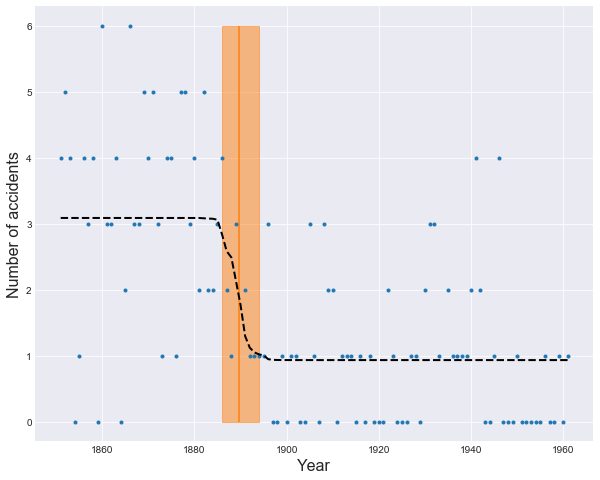

In [99]:
plt.figure(figsize=(10,8))
plt.plot(years, disaster_data, '.')
plt.ylabel('Number of accidents', fontsize=16)
plt.xlabel('Year', fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')

average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)
    
sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()], 
                 x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1')
plt.plot(years, average_disasters, 'k--', lw=2)
pass

### Arbitrary deterministics

An important drawback of this approach is that it is not possible for theano to inspect these functions in order to compute the gradient required for the Hamiltonian-based samplers. Therefore, it is not possible to use the HMC or NUTS samplers for a model that uses such an operator. However, it is possible to add a gradient if we inherit from theano.Op instead of using as_op. The PyMC example set includes [a more elaborate example of the usage of as_op](https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/disaster_model_theano_op.py).

In [103]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3
    
with pm.Model() as model_deterministic:
    a = pm.Poisson('a', 1)
    b = crazy_modulo3(a)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


## More Customization

### Arbitrary distributions
For simple statistical distributions, the DensityDist function takes as an argument any function that calculates a log-probability 𝑙𝑜𝑔(𝑝(𝑥)). This function may employ other random variables in its calculation. 

In [106]:
with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X1, sigma=eps, observed=Y)

For more complex distributions, one can create a **subclass of Continuous or Discrete** and **provide the custom logp function**, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using as_op or inheriting from theano.Op.

In [108]:
class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu
        
    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)

with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


## Generalized Linear Models

In [109]:
# convert X and Y into pd dataframe
df = pd.DataFrame({'x1':X1, 'x2':X2, 'y':Y})

In [110]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3397.73draws/s]


The error distribution, if not specified via the family argument, is assumed to be normal. In the case of logistic regression, this can be modified by passing in a Binomial family object.

In [111]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
